In [3]:
# standard libraries 
# networkx = 2.7
# cdt = 
# scipy = 1.8
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from tueplots import axes, bundles , figsizes, fonts,fontsizes
#import seaborn as sns
import random 
from random import randrange
import time

In [4]:
# causal discovery
import networkx as nx
import cdt 
from cdt import SETTINGS
from cdt.independence.graph import FSGNN
from cdt.causality.pairwise import GNN
from cdt.utils.graph import dagify_min_edge
from cdt.causality.graph import CGNN

# read in data 

In [5]:
nsw = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv') # RCT
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv') # RCT 
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv') # Quasi data 
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv') # Quasi data 
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv') # Quasi data 
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv') # Quasi data 

<p> organise data </p>

In [19]:
dataset_baseline_1 = nsw
dataset_baseline_2 = nswre74

# quasi experimental datasets 
dataset1 = nswCps_lalonde
dataset2 = nswPsid_lalonde
dataset3 = nswCps_dehWab
dataset4 = nswPsid_dehWab


dataset_subset1  = ['treat','age', 'education*', 'black', 'hispanic', 'married', 'nodegree','re75','re78']
dataset_subset2  = ['treat','age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're74','re75','re78']
features  = ['age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're75']
target = "treat"

<p> KEY </p>
<p> 0 = lalonde nsw rct </p>
<p> 1 = nsw treated + CPS control  (Lalonde's original sample) </p>
<p> 2 = nsw treated + PSID control (Lalonde's original sample) </p>
<p> 3 = nsw treated + CPS control  (Dehejia & Wahba sub-sample) </p>
<p> 4 = nsw treated + PSID control (Dehejia & Wahba sub-sample) </p>

In [7]:
# Key variables needed for DAGs
# 1 = individual/unit 
# 2 = outcome variable = wage in 1978 
# 3 = intervention/treatment variable  = treat column

In [9]:
from cdt.metrics import (precision_recall, SID, SHD)

# DAG NSW CPS Dehejia and Wahba

In [10]:
# Graph neural network for feature selection 
# 0. Create FSGNN object
Fsgnn = FSGNN(train_epochs=1000, test_epochs=500, l1=0.1, batch_size=1000)

In [ ]:
# 1 .  Create a skeleton graph  1 
start_time = time.time()
ugraph = Fsgnn.predict(dataset1[dataset_subset1], threshold=1e-7)
print("--- Execution time (skeleton) : %4.4s seconds ---" % (time.time() - start_time))

# 36 MINUTES

<p> glass o</p>

In [17]:
from cdt.independence.graph import Glasso
df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
obj = Glasso()
skeleton_graph_glasso1 = obj.predict(dataset1[dataset_subset1],max_iter = 100)
start_time = time.time()
print("--- Execution time (skeleton-glasso) : %4.4s seconds ---" % (time.time() - start_time))

--- Execution time (skeleton-glasso) : 7.20 seconds ---


<p> decision tree skeleton <p>

In [25]:
from cdt.independence.graph import DecisionTreeRegression
features  = ['age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're75','re78']
df_features = pd.DataFrame(dataset1[features])
df_target = pd.DataFrame(dataset1[target])
obj = DecisionTreeRegression()
output = obj.predict_features(df_features, df_target)
skeleton_graph_tree1= obj.predict(df_features)

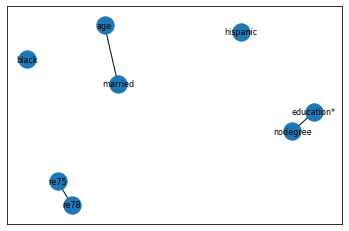

,0,1,2
0,age,married,0.050392
1,education*,nodegree,0.292129
2,re75,re78,0.258763


In [26]:
# plot skeleton graph
nx.draw_networkx(skeleton_graph_tree1, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
pd.DataFrame(list(skeleton_graph_tree1.edges(data='weight')))

In [ ]:
#2 . Generate Pairwise causal inference model 
start_time = time.time()
gnn = GNN(nruns=5, train_epochs=5, test_epochs=5, batch_size=1000)
ograph = dagify_min_edge(gnn.orient_graph(dataset3[dataset_subset1], ugraph)) 
print("--- Execution time (pairwise): %4.4s seconds ---" % (time.time() - start_time))

In [ ]:
# 3.  Run causal GNN
start_time = time.time()
Cgnn = CGNN(nruns=5, train_epochs=5, test_epochs=5, batch_size=1000)
dgraph = Cgnn.orient_directed_graph(dataset3[dataset_subset], ograph)
print("--- Execution time (cgnn): %4.4s seconds ---" % (time.time() - start_time))

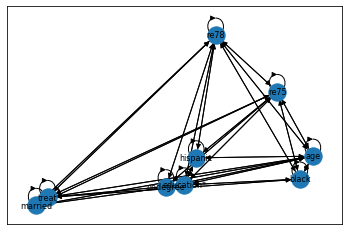

,0,1,2
0,treat,treat,5.765214e+01
1,treat,age,4.141881e-02
2,treat,education*,9.154644e-02
3,treat,black,-1.575603e+00
4,treat,re75,7.675274e-05
...,...,...,...
58,re78,hispanic,5.216862e-06
59,re78,married,-9.728370e-06
60,re78,nodegree,-9.261473e-07
61,re78,re75,-1.392257e-08


In [18]:
# plot skeleton graph
nx.draw_networkx(skeleton_graph_glasso1, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
pd.DataFrame(list(skeleton_graph_glasso1.edges(data='weight')))

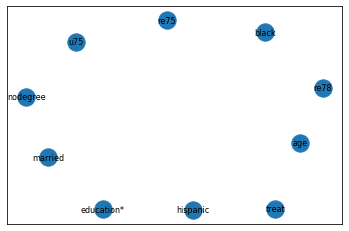

,treat,re78,Score


In [86]:
#Plot pairwise graph
nx.draw_networkx(ograph, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
pd.DataFrame(list(ograph.edges(data='weight')), columns=['treat', 're78', 'Score'])

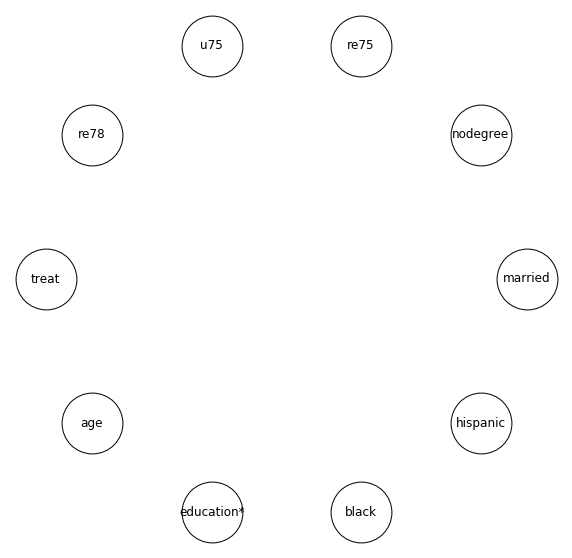

In [87]:
# Plot directed graph
G1 = dgraph
fig, ax = plt.subplots(figsize = (10,10))
nx.draw_shell(G1, with_labels=True,node_color='white', edgecolors = "black",font_color = "black",node_size=3700)
# The plot function allows for quick visualization of the graph.

# Print output results : 
pd.DataFrame(list(dgraph.edges(data='weight')), columns=['Cause', 'Effect', 'Score'])
plt.show() 

# Dataset 1 - NSW CPS

In [14]:
# Finding the structure of the graph
# Create a skeleton graph 
start_time = time.time()
ugraph = Fsgnn.predict(dataset1[dataset_subset1], threshold=1e-7)
print("--- Execution time : %4.4s seconds ---" % (time.time() - start_time))
nx.write_gpickle(ugraph,'/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/pickled graphs/dataset1_skeleton_graph.gpickle')
nx.draw_networkx(ugraph, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
# List results
pd.DataFrame(list(ugraph.edges(data='weight')))
# 11 minutes


KeyboardInterrupt: 

In [28]:
#nx.write_gpickle(ugraph,'/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/pickled graphs/dataset1_skeleton_graph.gpickle') # save the undirected graph 

In [5]:
#ugraph = nx.read_gpickle('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/pickled graphs/dataset1_skeleton_graph.gpickle')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_11312/3206901575.py", line 1, in <cell line: 1>
    ugraph = nx.read_gpickle('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/pickled graphs/dataset1_skeleton_graph.gpickle')
  File "/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/networkx/utils/decorators.py", line 816, in func
    return argmap._lazy_compile(__wrapper)(*args, **kwargs)
  File "<class 'networkx.utils.decorators.argmap'> compilation 5", line 5, in argmap_read_gpickle_1
  File "/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/networkx/readwrite/gpickle.py", line 109, in read_gpickle
    return pickle.load(path)
  File "/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/networkx/classes/

--- Execution time : 860. seconds ---


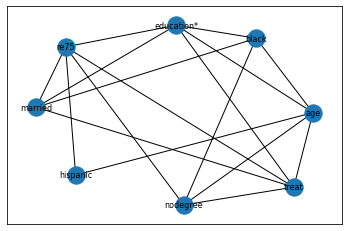

,treat,re78,Score
0,age,treat,0.213096
1,age,hispanic,0.675921
2,treat,re75,0.190853
3,education*,treat,0.468585
4,education*,age,0.103730
5,education*,re75,0.196365
6,married,treat,0.112598
7,married,education*,0.020509
8,married,re75,0.544803
9,nodegree,treat,0.333031


In [10]:
# Pairwise causal inference model 
# This block of code takes in an undirected graph and produced a directed graph 

# gnn = shallow generative Neural network
        # pairwise network, to model the causal direction x -> , y -> with 1 hidden layer 
        # https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#gnn

# gnn(nruns = nruns (int)  
#              number of runs to execute per batch 
#              (before testing for significance with t-test). 
#     )

# orient_graph = orient an undirected graph
#       inputs = (dataset, undirected graph) 
#        output = directed graphj

# dagify_min_edge = input's a graph and outputs a DAF
                    # heuristic is to reverse the edge with the lowest score of the cycle if possible, else remove it.
                    # dagify_min_edge() input = network x graph 

from cdt.causality.pairwise import GNN
from cdt.utils.graph import dagify_min_edge
start_time = time.time()
gnn = GNN(nruns=5, train_epochs=10, test_epochs=5, batch_size=1000)

# input data into the graph = dataset2[dataset_subset]
# ugraph = an undirected graph 
# gnn(nruns = nruns (int)  
#              number of runs to execute per batch 
#              (before testing for significance with t-test). 
#     )
ograph = dagify_min_edge(gnn.orient_graph(dataset2[dataset_subset], ugraph)) 
print("--- Execution time : %4.4s seconds ---" % (time.time() - start_time))
nx.draw_networkx(ugraph, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
# List results
pd.DataFrame(list(ograph.edges(data='weight')), columns=['Cause', 'Effect', 'Score'])

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


--- Execution time : 1.50 seconds ---


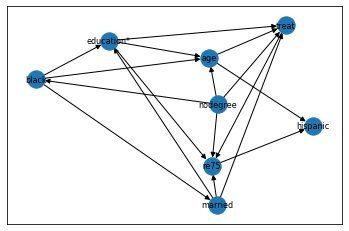

,Cause,Effect,Score
0,age,treat,0.213096
1,age,hispanic,0.675921
2,treat,re75,0.190853
3,education*,treat,0.468585
4,education*,age,0.103730
5,education*,re75,0.196365
6,married,treat,0.112598
7,married,education*,0.020509
8,married,re75,0.544803
9,nodegree,treat,0.333031


In [11]:
# CGNN = causal generative neural network
# Score-method that evaluates candidate graph by generating data 
# following the topological order of the graph using neural networks, 
# and using MMD for evaluation.
Cgnn = CGNN(nruns=16, train_epochs=5, test_epochs=5, batch_size=1000)
start_time = time.time()
dgraph = Cgnn.orient_directed_graph(dataset_baseline_1[dataset_subset], ograph)
print("--- Execution time : %4.4s seconds ---" % (time.time() - start_time))
# Plot the output graph
nx.draw_networkx(dgraph, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show() 
# Print output results : 
pd.DataFrame(list(dgraph.edges(data='weight')), columns=['Cause', 'Effect', 'Score'])

In [ ]:
# causal_graph(data,undirected grapj,[cause,effect,score])